In [8]:
import xarray as xr
import numpy  as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
import pickle

In [9]:
df = pd.read_pickle("/glade/work/hpzhang/LCC_pred/data/data_monthly.pkl").dropna()
df = df[df.index.year.isin(np.arange(2003,2019))]
df = df[['LCF','EIS','LH','dQ','RH700','OMEGA700','U1000','Tadv']]


In [10]:
df.head()

,LCF,EIS,LH,dQ,RH700,OMEGA700,U1000,Tadv
time,,,,,,,,
2003-01-15,0.590822,7.073290,-14.891875,0.001997,69.974464,0.005796,3.637893,0.898143
2003-01-15,0.590822,6.971072,-13.840185,0.002030,69.732834,0.010119,3.618882,-0.020427
2003-01-15,0.556442,6.874149,-13.721111,0.002075,69.224571,0.008408,3.703815,-0.006477
2003-01-15,0.556442,6.813395,-12.907546,0.002108,69.139580,0.004445,3.733388,0.069008
2003-01-15,0.584355,6.751677,-12.451134,0.002122,69.027931,0.000932,3.706906,-1.276983


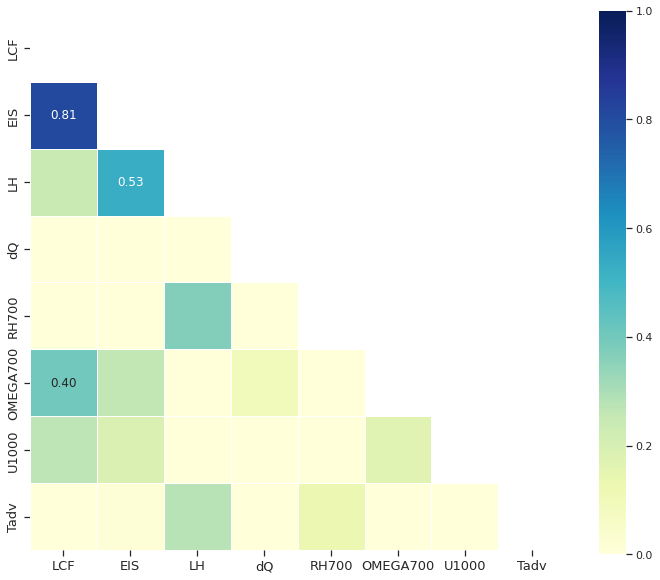

In [11]:
corr = df.corr()

#custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", font_scale = 1.0)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

def my_mask(x):
    if x < 0.4:
        y = ''
    else:
        y = '{0:.2f}'.format(x)
    return(y)

f, ax = plt.subplots(figsize=(12, 10))
g1 = sns.heatmap(corr, ax=ax,
                 vmin=0, vmax=1,
                 annot=corr.applymap(my_mask), fmt='',
                 square=True,
                 mask=mask,
                 cmap="YlGnBu",
                 linewidths=.5)
g1.set_xticklabels(g1.get_xmajorticklabels(), fontsize = 13)
g1.set_yticklabels(g1.get_ymajorticklabels(), fontsize = 13)
plt.show()

In [12]:
data = df
index_train = data.index.year.isin(np.arange(2003,2015))
index_test  = data.index.year.isin(np.arange(2015,2019))
data_train = data[index_train]
data_test  = data[index_test]

X_train, y_train = data_train.iloc[:,1:], data_train.iloc[:,0]
X_test, y_test   = data_test.iloc[:,1:], data_test.iloc[:,0]

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [13]:
### Linear regression
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

lr_model = linear_model.LinearRegression()
lr_model.fit(X_train_scaled, y_train)

### save model ###
file_name = "/glade/work/hpzhang/LCC_pred/data/lr_reg.pkl"
pickle.dump(lr_model, open(file_name, "wb"))

y_pred_lr = lr_model.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print('Mean squared error from linear regression: ', mse_lr)
print('Mean absolute error from linear regression: ', mae_lr)

# summarize feature importance
feature_list = list(data.columns[1:])
feature_imp_lr = pd.Series(abs(lr_model.coef_), index=feature_list).sort_values(ascending=False)
print(feature_imp_lr)

Mean squared error from linear regression:  0.007636191414568694
Mean absolute error from linear regression:  0.06513416041417992
EIS         0.126036
LH          0.033632
dQ          0.027660
OMEGA700    0.025818
U1000       0.011550
Tadv        0.007165
RH700       0.003977
dtype: float64


In [14]:
### output ###

var = 'Qu'
os.system("mkdir -p /glade/work/hpzhang/LCC_pred/data/{}".format(var))
np.save("/glade/work/hpzhang/LCC_pred/data/{}/y_pred_lr.npy".format(var), np.array(y_pred_lr))
